### Prepare VOR data for analysis

#### Package inputs

In [1]:
import os
import pandas as pd
import geopandas as gpd
import re
import numpy as np
from shapely.geometry import Point, LineString, shape, Polygon, MultiPoint
import pickle
import seaborn as sns
from datetime import datetime

ERROR 1: PROJ: proj_create_from_database: Open of /project/cper_neon_aop/conda_envs/hls_nrt_env/share/proj failed


#### Specify parameters

##### Specify input paths

In [42]:
# set working directory to root
#os.chdir('/mnt/c/Users/Sean.Kearney/git_repos/cper_hls_veg_models')
os.chdir('/project/cper_neon_aop/cper_hls_veg_models')

# annual VOR data from all pastures
#base_vor_dir = '/mnt/t/4-DataCatalog/CARM/VOR/'
#vor_june_f = os.path.join(base_vor_dir, 'CARM_VOR_JUN_cln_attr2024-03-22.csv')
#vor_oct_f = os.path.join(base_vor_dir, 'CARM_VOR_OCT_cln_attr2024-03-22.csv')
#vor_ann_base_dir = '/mnt/2-Projects/AGM/Measurements - Annual Decisions/Vegetation/VOR/'

# annual VOR data from all pastures - ignoring 2013 because fewer VOR samples taken
vor_june_dict = {}
for y in range(2014, 2024):
    vor_june_dict[y] = 'data/ground/vor/carm_vor_june_{}_raw.csv'.format(str(y))
vor_oct_dict = {}
for y in range(2014, 2024):
    vor_oct_dict[y] = 'data/ground/vor/carm_vor_oct_{}_raw.csv'.format(str(y))

# weekly VOR data from CARM pastures
vor_wkly_dict = {}
for y in range(2014, 2024):
    vor_wkly_dict[y] = 'data/ground/vor/Weekly_VOR_{}_simp.csv'.format(str(y))

# cper pastures shapefile
#cper_f = '/mnt/t/3-GIS/CPER/Layers/Pasture_Boundaries/Shapefiles/cper_pastures_2022_w_exclosures_spk.shp'
cper_f = 'data/ground/boundaries/cper_pastures_2022_w_exclosures_spk.shp'
# transects shapefile
#transects_f = "/mnt/t/3-GIS/CPER/Layers/Plots_Transects/CPER_VOR_Transects_all_2020_Oct14.shp"
transects_f = 'data/ground/boundaries/CPER_VOR_Transects_all_2020_Oct14_clean.shp'

# biomass~VOR linear regression model file
mod_vor_lr_f = './models/biomass/CPER_VOR_to_biomass_model_20240325.pk'

##### Specify species and other cleaning parameters

In [43]:
# list of species to remove from datasets
spp_rem = ['OPPO', 'ATCA', 'GUSA', 'EREF', 'ARFR', 'ERNA', 'KRLA', 'YUGL']

# dictionary of species names to change
spp_chg = {"ANT": "BARE", "ARME": "ARPO", "CACU": "CADU", "CAIN": "CANE", "CELA": "KRLA", "CMRI": "CRMI",
           "EBNU": "EVNU", "LYGU": "LYJU", "SIAB": "SAIB", "SIHY": "ELEL", "STCO": "HECO",
           "UNK": "UNKN", "UNKF": "UNFB", "UKNF": "UNFB", "VUO": "VUOC", "BA": "BARE", "BU": "BUDA",
           "CA": "CADU", "HE": "HECO", "VU": "VUOC", "BNO": "BOGR", "BRTI": "BRTE", "LITTT": "LITT",
           "ALIT": "ALTE", "BGOR": "BOGR", "VARE": "BARE", "ALTI": "ALTE", "AT": "ATCA", "BR": "BRTE",
           "KLI": "KRLA", "LOPP": "OPPO", "PA": "PASM", "POASM": "PASM", "SP": "SPAI", "VO": "VUOC",
           "oldforb": "FORB", "BO": "BOBU", "std": "SD", "stde": "SD", "bu": "BUDA", "vo": "VUOC", "vouc": "VUOC",
           "AFRF": "ARFR", "LIT": "LITT", "lit": "LITT"}

# coefficients for VOR to biomass regression
coef_intcp = 32.9
coef_low = 133.6
coef_hi = 23.7

# set experimental unit to plot' or 'transect'
exp_unit = "plot"

# set filters for VOR
max_vor_low = 100
max_vor_hi = 200
max_sd = 3.0

# create transect pasture renaming dictionary
trans_name_dict = {
    'NH': '10S',
    '7se': '7SE',
    '31w': '31W',
    '26w': '26W',
    '25nw': '25NW',
    '17s': '17S',
    '18s': '18S',
    '19n': '19N',
    '21n': '21N',
    '22SW': '22W'
}

# create vor pasture renaming dictionary
vor_name_dict = {
    '18S_burn': '18S',
    '7SE_salt': '7SE',
    'NH': '10S',
    '20NW_saltflat': '20NW',
    '29-30': '2930'
}

# create vor plot renaming dictionary
vor_plot_dict = {
    '4_burn': '4'
}

In [44]:
def group_max_vor(x, cols, sds):
    if len(cols) > 1:
        mu = x[cols].max(axis=1).mean()
        sd = x[cols].max(axis=1).std()
    else:
        mu = x[cols].mean()
        sd = x[cols].std()
    return mu + sd*sds

#### Prepare all variable objects

##### Read in datasets and models

In [45]:
# read in weekly VOR csv's
for i,k in enumerate(vor_wkly_dict):
    if i == 0:
        df_vor_wkly = pd.read_csv(vor_wkly_dict[k])
        # rename columns
        df_vor_wkly = df_vor_wkly.rename(columns={'Reading #': 'Reading_No'})
    else:
        df_vor_wkly_tmp = pd.read_csv(vor_wkly_dict[k], encoding='cp1252')
        df_vor_wkly_tmp = df_vor_wkly_tmp.rename(columns={'Reading #': 'Reading_No'})
        df_vor_wkly = pd.concat([df_vor_wkly, df_vor_wkly_tmp])
df_vor_wkly = df_vor_wkly.reset_index(drop=True)

In [46]:
june_col_drop = ['General Ecosite', 
                 'Average High',
                 'Average Low',
                 'MeanLow', 
                 'MeanHigh',
                 'EcoSite', 
                 'Year'
                ]

june_col_rename = {
    'East-High': 'East_High1',
    'High East': 'East_High1',
    'East-Low': 'East_Low1',
    'Low East': 'East_Low1',
    'West-High': 'West_High2',
    'High West': 'West_High2',
    'West-Low': 'West_Low2',
    'Low West': 'West_Low2',
    'East-Spp': 'East_SppLo',
    'Spp East': 'East_SppLo',
    'East-Low-Spp': 'East_SppLo',
    'West-Spp': 'West_SppLo',
    'Spp West': 'West_SppLo',
    'West-Low-Spp': 'West_SppLo',
    'East-High-Spp': 'East_SppHi',
    'West-High-Sp': 'West_SppHi',
    'West-High-Spp': 'West_SppHi',
    'Transect ': 'Transect',
    ' Distance': 'Distance',
    'Date': 'SamplingDate'
}
oct_col_drop = ['Ecosite',
                'Screen 1', 
                'Screen 2 ',
                'Low 1',
                'Low 2 ',
                'Low1',
                'Low2',
                'Mean Low Filtered',
                'MeanLowAll', 
                'ForageSppCheck',
                'ForageSppCheck.1', 
                'LowFor-E',
                'LowFor-W',
                'MeanLowFor', 
                'EcoSite',
                'MeanHigh', 
                'MeanLow',
                'Mean High',
                'Mean Low',
                'Treatment', 
                'Screen1', 
                'Screen2',
                'MeanLow(forage)',
                'ID', 
                'Season',
                'Year'
               ]
oct_col_rename = {'Low-E': 'East_Low1',
                  'East-Low': 'East_Low1',
                  'Low East': 'East_Low1',
                  'High-E': 'East_High1',
                  'High East': 'East_High1',
                  'East-High': 'East_High1',
                  'Spp-E': 'East_SppLo',
                  'Spp East': 'East_SppLo',
                  'EastLowSpp': 'East_SppLo',
                  'East-Low-Spp': 'East_SppLo',
                  'EastHighSpp': 'East_SppHi',
                  'East-High-Spp': 'East_SppHi',
                  'Low-W': 'West_Low2',
                  'Low West': 'West_Low2',
                  'West-Low': 'West_Low2',
                  'High-W': 'West_High2', 
                  'High West': 'West_High2',
                  'West-High': 'West_High2', 
                  'Spp-W': 'West_SppLo',
                  'Spp West': 'West_SppLo', 
                  'WestLowSpp': 'West_SppLo',
                  'West-Low-Spp': 'West_SppLo',
                  'WestHighSpp': 'West_SppHi', 
                  'West-High-Sp': 'West_SppHi',
                  'Date': 'SamplingDate',
                  'Transect ': 'Transect',
                  ' Distance': 'Distance'
                 }

fnl_col_order = ['Year', 'SamplingDate', 'Pasture', 'Plot', 'Transect', 'Distance', 
                 'East_Low1', 'East_SppLo', 'West_Low2', 'West_SppLo', 
                 'East_High1', 'East_SppHi', 'West_High2', 'West_SppHi',
                 'Notes'
                ]
# read in june VOR csv's
for i,k in enumerate(vor_june_dict):
    df_vor_june_tmp = pd.read_csv(vor_june_dict[k])
    df_vor_june_tmp = df_vor_june_tmp.drop(
            columns=june_col_drop + [x for x in df_vor_june_tmp.columns if 'Unnamed:' in x],
        errors='ignore')
    df_vor_june_tmp = df_vor_june_tmp.rename(columns=june_col_rename)
    df_vor_june_tmp['Year'] = k
    if i == 0:
        df_vor_june = df_vor_june_tmp.copy()
    else:
        df_vor_june = pd.concat([df_vor_june, df_vor_june_tmp])
df_vor_june = df_vor_june[fnl_col_order]

# read in oct VOR csv's
for i,k in enumerate(vor_oct_dict):
    df_vor_oct_tmp = pd.read_csv(vor_oct_dict[k])
    df_vor_oct_tmp = df_vor_oct_tmp.drop(
            columns=oct_col_drop + [x for x in df_vor_oct_tmp.columns if 'Unnamed:' in x],
        errors='ignore')
    df_vor_oct_tmp = df_vor_oct_tmp.rename(columns=oct_col_rename)
    df_vor_oct_tmp['Year'] = k
    if i == 0:
        df_vor_oct = df_vor_oct_tmp.copy()
    else:
        df_vor_oct = pd.concat([df_vor_oct, df_vor_oct_tmp], ignore_index=True)
df_vor_oct = df_vor_oct[fnl_col_order]

In [47]:
# read in shapefiles
gdf_cper = gpd.read_file(cper_f)
gdf_transects = gpd.read_file(transects_f)

In [48]:
# read in biomass~VOR linear regression model
with open(mod_vor_lr_f, 'rb') as f:
    mod_vor_lr = pickle.load(f)

##### Clean up and prepare transects

In [49]:
# rename transect pasture names to match pasture shapefile
gdf_transects['PastureNm'] = gdf_transects['PastureNm'].apply(
    lambda x: trans_name_dict[x] if x in trans_name_dict.keys() else x)

# remove prefixes for transect names
gdf_transects['Transect'] = gdf_transects['Transect'].apply(
    lambda x: re.sub("P", "", re.sub("T", "", str(x))))

# create unique transect id's
gdf_transects['Id_transect'] = gdf_transects.apply(
    lambda x: "_".join([x['PastureNm'], x['Plot_Num'], str(int(x['Transect']))]),
    axis=1)

# create unique plot id's
gdf_transects['Id_plot'] = gdf_transects.apply(lambda x: "_".join([x['PastureNm'],
                                                                   x['Plot_Num']]), axis=1)

# create transect geometry from coordinates
#gdf_transects['geometry'] = gdf_transects['geometry'].apply(lambda x: x.coords[0])

# create plot-scale geodataframe using convex hull and buffer by 15 m
gdf_plots = gdf_transects.groupby(['Id_plot'])['geometry'].apply(lambda x: MultiPoint(x.tolist()).convex_hull)
gdf_plots = gpd.GeoDataFrame(gdf_plots, geometry='geometry', crs=gdf_transects.crs).buffer(15)

# convert transect-scale geodataframe to polygon using convex hull and buffer by 15 m
gdf_transects = gdf_transects.groupby(['Id_transect'])['geometry'].apply(lambda x: MultiPoint(x.tolist()).convex_hull)
gdf_transects = gpd.GeoDataFrame(gdf_transects, geometry='geometry', crs=gdf_plots.crs).buffer(15)

<AxesSubplot:>

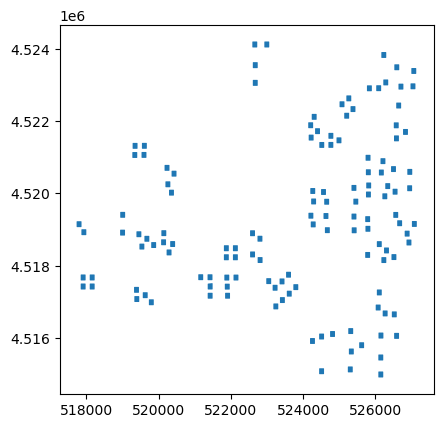

In [50]:
gdf_plots.plot()

<AxesSubplot:>

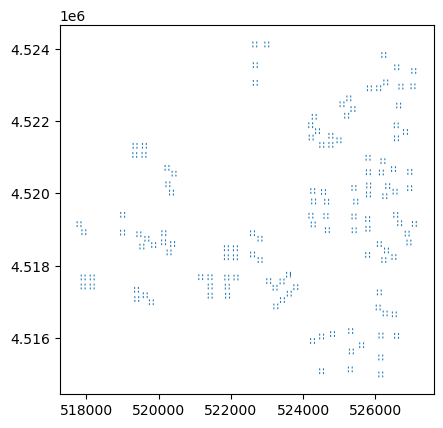

In [51]:
gdf_transects.plot()

##### Clean up and prepare weekly VOR

In [52]:
# drop unneccesary columns
df_vor_wkly = df_vor_wkly.drop(columns=['V_E_F', 'G_UG']).copy()

# drop any rows where all columns are NA
df_vor_wkly = df_vor_wkly.dropna(how='all').copy()

### RENAMING
# rename pastures to match shapefiles
df_vor_wkly['Pasture'] = df_vor_wkly['Pasture'].apply(lambda x: vor_name_dict[x] if x in vor_name_dict.keys() else x)
# convert pasture names to upper case
df_vor_wkly['Pasture'] = df_vor_wkly['Pasture'].str.upper() 
# rename plots to match shapefiles
df_vor_wkly['Plot'] = df_vor_wkly['Plot'].apply(lambda x: vor_plot_dict[x] if x in vor_plot_dict.keys() else x)
# add "P" to plot number and convert to string
df_vor_wkly['Plot'] = "P" + df_vor_wkly['Plot'].astype('str')

### DATES
# get all week data into one place and drop strangely named week column
df_vor_wkly.loc[df_vor_wkly['Week'].isnull(), 'Week'] = df_vor_wkly['ï»¿Week'][df_vor_wkly['Week'].isnull()]
df_vor_wkly = df_vor_wkly.drop(columns=['ï»¿Week']).copy()
# convert Date column to datetime
df_vor_wkly['Date'] = pd.to_datetime(df_vor_wkly['Date'])
# manually fix erroneous date for 2016
df_vor_wkly.loc[df_vor_wkly['Date'] == '2016-04-12', 'Date'] = pd.to_datetime('2016-05-12')
# add Year column
df_vor_wkly['Year'] = df_vor_wkly['Date'].dt.year
# get date as integer timestamp for averaging later
df_vor_wkly['Date_as_int'] = df_vor_wkly['Date'].values.astype(np.int64)

### FIX 'Low' READINGS
# convert Low readings of 'dung' to zeros
df_vor_wkly.loc[df_vor_wkly['Low'] == 'dung', 'Low'] = 0
# convert Low readings to numeric
df_vor_wkly['Low'] = df_vor_wkly['Low'].astype('float')

### FIX SPECIES
# remove any spaces in species names
df_vor_wkly['Spp'] = df_vor_wkly['Spp'].apply(lambda x: re.sub(' ', '', str(x)))  
df_vor_wkly['H.Spp'] = df_vor_wkly['H.Spp'].apply(lambda x: re.sub(' ', '', str(x)))  
# replace erroneous species names
for name_old, name_new in spp_chg.items():
    df_vor_wkly['Spp'] = df_vor_wkly['Spp'].replace(name_old, name_new)  
    df_vor_wkly['H.Spp'] = df_vor_wkly['H.Spp'].replace(name_old, name_new)  
# convert all species names to upper case
df_vor_wkly['Spp'] = df_vor_wkly['Spp'].str.upper()  
df_vor_wkly['H.Spp'] = df_vor_wkly['H.Spp'].str.upper()  

### REMOVING OBSERVATIONS
# remove nonsensical data
df_vor_wkly = df_vor_wkly[~(df_vor_wkly['Low'] > df_vor_wkly['High'])].copy()
# remove observations where Comments column indicates
df_vor_wkly = df_vor_wkly[~(df_vor_wkly['Comments'].str.contains("emove", na=False))]
# remove non-herbaceous species
df_vor_wkly = df_vor_wkly[~(df_vor_wkly['Spp'].isin(spp_rem))]
df_vor_wkly = df_vor_wkly[~(df_vor_wkly['H.Spp'].isin(spp_rem))]

# remove very high VOR readings based on value
df_vor_wkly.loc[df_vor_wkly['Low'] > max_vor_low, 'Low'] = np.nan
df_vor_wkly.loc[df_vor_wkly['High'] > max_vor_hi, 'High'] = np.nan

# remove very high VOR readings based on distributions to catch possible shrubs
max_vor_sds = df_vor_wkly.groupby(['Year', 'Pasture', 'Plot', 'Date']).apply(
    lambda x: group_max_vor(x, ['High'], max_sd)).reset_index().rename(columns={'High': 'High_max_w_sds'})
df_vor_wkly = pd.merge(df_vor_wkly, max_vor_sds, on=['Year', 'Pasture', 'Plot', 'Date'], how='left')
df_vor_wkly.loc[df_vor_wkly['High'] > df_vor_wkly['High_max_w_sds'], 'High'] = np.nan

df_vor_wkly = df_vor_wkly.drop(columns=['High_max_w_sds'])

### FIX GREEN AND BROWN READINGS
# make all 'G' and 'B' readings lowercase
df_vor_wkly.loc[df_vor_wkly['G_B'] == 'G', 'G_B'] = 'g'
df_vor_wkly.loc[df_vor_wkly['G_B'] == 'B', 'G_B'] = 'b'

### CREATE ID - ONLY POSSIBLE AT PLOT LEVEL FOR WEEKLY DATA
df_vor_wkly['Id_plot'] = df_vor_wkly.apply(lambda x: "_".join([x['Pasture'],
                                                               x['Plot']]), 
                                           axis=1)

##### Clean up and prepare June VOR

In [53]:
### INITIAL CLEANUP
# drop any rows where all columns are NA
df_vor_june = df_vor_june.dropna(how='all', subset=[x for x in fnl_col_order if x != 'Year']).copy()

### RENAMING
# rename pastures to match shapefiles
df_vor_june['Pasture'] = df_vor_june['Pasture'].apply(lambda x: vor_name_dict[x] if x in vor_name_dict.keys() else x)
# convert pasture names to upper case
df_vor_june['Pasture'] = df_vor_june['Pasture'].str.upper() 
# add "P" to plot number and cover to string
df_vor_june['Plot'] = "P" + df_vor_june['Plot'].astype('int').astype('str')

### DATES
# fix date issue in 2020 data
df_vor_june.loc[(df_vor_june['Year'] == 2020) & (df_vor_june['SamplingDate'] == '11-Jun'), 'SamplingDate'] = '6/11/2020'
# convert Year column to integer
df_vor_june['Year'] = df_vor_june['Year'].astype(int)
# manually fix date errors
df_vor_june.loc[(df_vor_june['Year'] == 2020) & (df_vor_june['SamplingDate'] == '6/11'),
'SamplingDate'] = pd.to_datetime('2020-6-11')
# convert SamplingDate column to datetime
df_vor_june['SamplingDate'] = pd.to_datetime(df_vor_june['SamplingDate'])
# fill any missing dates with June 12th of that year
df_vor_june.loc[df_vor_june['SamplingDate'].isnull(), 
                'SamplingDate'] = pd.to_datetime('6/12/' + df_vor_june.loc[df_vor_june['SamplingDate'].isnull(), 'Year'].astype(str))
# additional manual fix of date errors
df_vor_june.loc[(df_vor_june['Year'] == 2019) & (df_vor_june['SamplingDate'].dt.year == 2013), 
'SamplingDate'] = pd.to_datetime('2019-6-13')
df_vor_june.loc[(df_vor_june['Year'] == 2018) & (df_vor_june['SamplingDate'].dt.year == 2014), 
'SamplingDate'] = pd.to_datetime('2018-6-19')
# rename date to match weekly data
df_vor_june = df_vor_june.rename(columns={'SamplingDate': 'Date'})
# get date as integer timestamp for averaging later
df_vor_june['Date_as_int'] = df_vor_june['Date'].values.astype(np.int64)
# get average date by pasture
df_vor_june['Date_mean'] = df_vor_june.groupby(['Year', 'Pasture'])['Date'].transform('mean')
# get average date as integer timestamp for averaging later
df_vor_june['Date_mean_as_int'] = df_vor_june['Date_mean'].values.astype(np.int64)

### FIX SPECIES
# remove any spaces in species names
df_vor_june['East_SppLo'] = df_vor_june['East_SppLo'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_june['West_SppLo'] = df_vor_june['West_SppLo'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_june['East_SppHi'] = df_vor_june['East_SppHi'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_june['West_SppHi'] = df_vor_june['West_SppHi'].apply(lambda x: re.sub(' ', '', str(x)))

# replace erroneous species names
for name_old, name_new in spp_chg.items():
    df_vor_june['East_SppLo'] = df_vor_june['East_SppLo'].replace(name_old, name_new)  
    df_vor_june['West_SppLo'] = df_vor_june['West_SppLo'].replace(name_old, name_new)
    df_vor_june['East_SppHi'] = df_vor_june['East_SppHi'].replace(name_old, name_new)  
    df_vor_june['West_SppHi'] = df_vor_june['West_SppHi'].replace(name_old, name_new)

# convert all species names to upper case
df_vor_june['East_SppLo'] = df_vor_june['East_SppLo'].str.upper()  
df_vor_june['West_SppLo'] = df_vor_june['West_SppLo'].str.upper()
df_vor_june['East_SppHi'] = df_vor_june['East_SppHi'].str.upper()  
df_vor_june['West_SppHi'] = df_vor_june['West_SppHi'].str.upper()

### FIX VOR READINGS AND SET NULLS WHERE NEEDED
# replace 90+ with 90, '.' with np.nan and convert to float
for c in ['East_Low1', 'East_High1', 'West_Low2', 'West_High2']:
    df_vor_june.loc[(df_vor_june[c] == '90+') | (df_vor_june[c] == '90 +'), c] = 90
    df_vor_june.loc[df_vor_june[c] == '.', c] = np.nan
    df_vor_june[c] = pd.to_numeric(df_vor_june[c], errors='coerce')
    
# remove nonsensical observation data
df_vor_june.loc[df_vor_june['East_Low1'] > df_vor_june['East_High1'], ['East_Low1', 'East_High1']] = [np.nan, np.nan]
df_vor_june.loc[df_vor_june['West_Low2'] > df_vor_june['West_High2'], ['West_Low2', 'West_High2']] = [np.nan, np.nan]

# remove non-herbaceous species
df_vor_june.loc[df_vor_june['East_SppLo'].isin(spp_rem), ['East_Low1', 'East_High1']] = [np.nan, np.nan]
df_vor_june.loc[df_vor_june['East_SppHi'].isin(spp_rem), 'East_High1'] = np.nan
df_vor_june.loc[df_vor_june['West_SppLo'].isin(spp_rem), ['West_Low2', 'West_High2']] = [np.nan, np.nan]
df_vor_june.loc[df_vor_june['West_SppHi'].isin(spp_rem), 'West_High2'] = np.nan

# remove very high VOR readings based on value
df_vor_june.loc[df_vor_june['East_Low1'] > max_vor_low, 'East_Low1'] = np.nan
df_vor_june.loc[df_vor_june['West_Low2'] > max_vor_low, 'West_Low2'] = np.nan
df_vor_june.loc[df_vor_june['East_High1'] > max_vor_hi, 'East_High1'] = np.nan
df_vor_june.loc[df_vor_june['West_High2'] > max_vor_hi, 'West_High2'] = np.nan

# remove very high VOR readings based on distributions to catch possible shrubs
max_vor_sds = df_vor_june.groupby(['Year', 'Pasture', 'Plot', 'Transect']).apply(
    lambda x: group_max_vor(x, ['East_High1', 'West_High2'], max_sd)).reset_index().rename(columns={0: 'High_max_w_sds'})
df_vor_june = pd.merge(df_vor_june, max_vor_sds, on=['Year', 'Pasture', 'Plot', 'Transect'], how='left')
df_vor_june.loc[df_vor_june['East_High1'] > df_vor_june['High_max_w_sds'], 'East_High1'] = np.nan
df_vor_june.loc[df_vor_june['West_High2'] > df_vor_june['High_max_w_sds'], 'West_High2'] = np.nan

df_vor_june = df_vor_june.drop(columns=['High_max_w_sds'])

### GET FINAL VOR MEANS
# get means of multiple low and high readings
df_vor_june['Low'] = np.nanmean(df_vor_june[['East_Low1', 'West_Low2']], axis=1)
df_vor_june['High'] = np.nanmean(df_vor_june[['East_High1', 'West_High2']], axis=1)

### REMOVE OBSERVATIONS
# remove nonsensical mean data
df_vor_june = df_vor_june[~(df_vor_june['Low'] > df_vor_june['High'])].copy()

### SET ID's
df_vor_june['Id_transect'] = df_vor_june.apply(lambda x: "_".join([x['Pasture'],
                                                                   x['Plot'],
                                                                   str(int(x['Transect']))]), 
                                               axis=1)
df_vor_june['Id_plot'] = df_vor_june.apply(lambda x: "_".join([x['Pasture'],
                                                               x['Plot']]), 
                                           axis=1)


/local/bgfs/sean.kearney/12167769/ipykernel_204025/2402607773.py:94: RuntimeWarning: Mean of empty slice
  df_vor_june['Low'] = np.nanmean(df_vor_june[['East_Low1', 'West_Low2']], axis=1)
/local/bgfs/sean.kearney/12167769/ipykernel_204025/2402607773.py:95: RuntimeWarning: Mean of empty slice
  df_vor_june['High'] = np.nanmean(df_vor_june[['East_High1', 'West_High2']], axis=1)


##### Clean up and prepare October VOR

In [54]:
### INITIAL CLEANUP
# drop any rows where all columns are NA
df_vor_oct = df_vor_oct.dropna(how='all', subset=[x for x in fnl_col_order if x != 'Year']).copy()

### RENAMING
# rename pastures to match shapefiles
df_vor_oct['Pasture'] = df_vor_oct['Pasture'].apply(lambda x: vor_name_dict[x] if x in vor_name_dict.keys() else x)
# convert pasture names to upper case
df_vor_oct['Pasture'] = df_vor_oct['Pasture'].str.upper() 
# add "P" to plot number and cover to string
df_vor_oct['Plot'] = "P" + df_vor_oct['Plot'].astype('int').astype('str')

### DATES
# manually fix date errors
df_vor_oct.loc[(df_vor_oct['Year'] == 2021) & (df_vor_oct['SamplingDate'] == '10/5/1931'), 'SamplingDate'] = '10/5/2021'
df_vor_oct.loc[(df_vor_oct['Year'] == 2023) & (df_vor_oct['SamplingDate'] == '2/26/2023'), 'SamplingDate'] = '9/26/2023'
# convert Year column to integer
df_vor_oct['Year'] = df_vor_oct['Year'].astype(int)
# convert SamplingDate column to datetime
df_vor_oct['SamplingDate'] = pd.to_datetime(df_vor_oct['SamplingDate'])
# fill any missing dates with oct 12th of that year
df_vor_oct.loc[df_vor_oct['SamplingDate'].isnull(), 
                'SamplingDate'] = pd.to_datetime('10/5/' + df_vor_oct.loc[df_vor_oct['SamplingDate'].isnull(), 'Year'].astype(str))
# rename date to match weekly data
df_vor_oct = df_vor_oct.rename(columns={'SamplingDate': 'Date'})
# get date as integer timestamp for averaging later
df_vor_oct['Date_as_int'] = df_vor_oct['Date'].values.astype(np.int64)
# get average date by pasture
df_vor_oct['Date_mean'] = df_vor_oct.groupby(['Year', 'Pasture'])['Date'].transform('mean')
# get average date as integer timestamp for averaging later
df_vor_oct['Date_mean_as_int'] = df_vor_oct['Date_mean'].values.astype(np.int64)

### FIX SPECIES
# remove any spaces in species names
df_vor_oct['East_SppLo'] = df_vor_oct['East_SppLo'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_oct['West_SppLo'] = df_vor_oct['West_SppLo'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_oct['East_SppHi'] = df_vor_oct['East_SppHi'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_oct['West_SppHi'] = df_vor_oct['West_SppHi'].apply(lambda x: re.sub(' ', '', str(x)))

# replace erroneous species names
for name_old, name_new in spp_chg.items():
    df_vor_oct['East_SppLo'] = df_vor_oct['East_SppLo'].replace(name_old, name_new)  
    df_vor_oct['West_SppLo'] = df_vor_oct['West_SppLo'].replace(name_old, name_new)
    df_vor_oct['East_SppHi'] = df_vor_oct['East_SppHi'].replace(name_old, name_new)  
    df_vor_oct['West_SppHi'] = df_vor_oct['West_SppHi'].replace(name_old, name_new)

# convert all species names to upper case
df_vor_oct['East_SppLo'] = df_vor_oct['East_SppLo'].str.upper()  
df_vor_oct['West_SppLo'] = df_vor_oct['West_SppLo'].str.upper()
df_vor_oct['East_SppHi'] = df_vor_oct['East_SppHi'].str.upper()  
df_vor_oct['West_SppHi'] = df_vor_oct['West_SppHi'].str.upper()

### FIX VOR READINGS AND SET NULLS WHERE NEEDED
# replace 90+ with 90, '.' with np.nan and convert to float
for c in ['East_Low1', 'East_High1', 'West_Low2', 'West_High2']:
    df_vor_oct.loc[(df_vor_oct[c] == '90+') | (df_vor_oct[c] == '90 +'), c] = 90
    df_vor_oct.loc[df_vor_oct[c] == '.', c] = np.nan
    df_vor_oct[c] = pd.to_numeric(df_vor_oct[c], errors='coerce')

# remove nonsensical observation data
df_vor_oct.loc[df_vor_oct['East_Low1'] > df_vor_oct['East_High1'], ['East_Low1', 'East_High1']] = [np.nan, np.nan]
df_vor_oct.loc[df_vor_oct['West_Low2'] > df_vor_oct['West_High2'], ['West_Low2', 'West_High2']] = [np.nan, np.nan]

# remove non-herbaceous species
df_vor_oct.loc[df_vor_oct['East_SppLo'].isin(spp_rem), ['East_Low1', 'East_High1']] = [np.nan, np.nan]
df_vor_oct.loc[df_vor_oct['East_SppHi'].isin(spp_rem), 'East_High1'] = np.nan
df_vor_oct.loc[df_vor_oct['West_SppLo'].isin(spp_rem), ['West_Low2', 'West_High2']] = [np.nan, np.nan]
df_vor_oct.loc[df_vor_oct['West_SppHi'].isin(spp_rem), 'West_High2'] = np.nan

# remove very high VOR readings based on value
df_vor_oct.loc[df_vor_oct['East_Low1'] > max_vor_low, 'East_Low1'] = np.nan
df_vor_oct.loc[df_vor_oct['West_Low2'] > max_vor_low, 'West_Low2'] = np.nan
df_vor_oct.loc[df_vor_oct['East_High1'] > max_vor_hi, 'East_High1'] = np.nan
df_vor_oct.loc[df_vor_oct['West_High2'] > max_vor_hi, 'West_High2'] = np.nan

# remove very high VOR readings based on distributions to catch possible shrubs
max_vor_sds = df_vor_oct.groupby(['Year', 'Pasture', 'Plot', 'Transect']).apply(
    lambda x: group_max_vor(x, ['East_High1', 'West_High2'], max_sd)).reset_index().rename(columns={0: 'High_max_w_sds'})
df_vor_oct = pd.merge(df_vor_oct, max_vor_sds, on=['Year', 'Pasture', 'Plot', 'Transect'], how='left')
df_vor_oct.loc[df_vor_oct['East_High1'] > df_vor_oct['High_max_w_sds'], 'East_High1'] = np.nan
df_vor_oct.loc[df_vor_oct['West_High2'] > df_vor_oct['High_max_w_sds'], 'West_High2'] = np.nan

df_vor_oct = df_vor_oct.drop(columns=['High_max_w_sds'])

### GET FINAL VOR MEANS
# get means of multiple low and high readings
df_vor_oct['Low'] = np.nanmean(df_vor_oct[['East_Low1', 'West_Low2']], axis=1)
df_vor_oct['High'] = np.nanmean(df_vor_oct[['East_High1', 'West_High2']], axis=1)

### REMOVE OBSERVATIONS
# remove nonsensical mean data
df_vor_oct = df_vor_oct[~(df_vor_oct['Low'] > df_vor_oct['High'])].copy()

### SET ID's
df_vor_oct['Id_transect'] = df_vor_oct.apply(lambda x: "_".join([x['Pasture'],
                                                                   x['Plot'],
                                                                   str(int(x['Transect']))]), 
                                               axis=1)
df_vor_oct['Id_plot'] = df_vor_oct.apply(lambda x: "_".join([x['Pasture'],
                                                               x['Plot']]), 
                                           axis=1)

### GET AVERAGE DATE BY ID
df_vor_oct['Date_mean'] = df_vor_oct.groupby(['Id_plot', 'Year', 'Pasture'])['Date'].transform('mean')

/local/bgfs/sean.kearney/12167769/ipykernel_204025/2777680803.py:87: RuntimeWarning: Mean of empty slice
  df_vor_oct['Low'] = np.nanmean(df_vor_oct[['East_Low1', 'West_Low2']], axis=1)
/local/bgfs/sean.kearney/12167769/ipykernel_204025/2777680803.py:88: RuntimeWarning: Mean of empty slice
  df_vor_oct['High'] = np.nanmean(df_vor_oct[['East_High1', 'West_High2']], axis=1)


In [60]:
# get average date by pasture
df_vor_june['Date_mean'] = df_vor_june.groupby(['Year', 'Pasture'])['Date'].transform('mean')
# get average date as integer timestamp for averaging later
df_vor_june['Date_mean_as_int'] = df_vor_june['Date_mean'].values.astype(np.int64)

# get average date by pasture
df_vor_oct['Date_mean'] = df_vor_oct.groupby(['Year', 'Pasture'])['Date'].transform('mean')
# get average date as integer timestamp for averaging later
df_vor_oct['Date_mean_as_int'] = df_vor_oct['Date_mean'].values.astype(np.int64)

#### Get experimental unit means and merge data

In [61]:
# prepare data for grouping
df_vor_wkly['Week'] = df_vor_wkly['Date'].dt.isocalendar().week
wkly_keep_cols = df_vor_wkly.select_dtypes(include=['number', 'datetime']).columns
wkly_group_cols = ['Year', 'Pasture', 'Id_plot', 'Week']
wkly_keep_cols =  list(set(list(wkly_keep_cols) + wkly_group_cols))

annual_keep_cols = df_vor_june.select_dtypes(include=['number', 'datetime']).columns
annual_group_cols = ['Year', 'Pasture', 'Id_plot', 'Id_transect']
annual_keep_cols = list(set(list(annual_keep_cols) + annual_group_cols))

# get means by experimental unit
df_vor_wkly_means = df_vor_wkly[wkly_keep_cols].groupby(wkly_group_cols).mean().round(2).reset_index()
df_vor_june_means = df_vor_june[annual_keep_cols].groupby(annual_group_cols).mean().round(2).reset_index()
df_vor_oct_means = df_vor_oct[annual_keep_cols].groupby(annual_group_cols).mean().round(2).reset_index()

In [62]:
# get dates
df_vor_wkly_means['Date'] = pd.to_datetime(df_vor_wkly_means['Date_as_int']).dt.date
df_vor_wkly_means['Date_mean'] = df_vor_wkly_means['Date']
df_vor_wkly_means = df_vor_wkly_means.drop(columns=['Date_as_int', 'Screen1', 'Reading_No', 'Biomass_lbs_ac', 'Adj_Low'])

df_vor_june_means['Date'] = pd.to_datetime(df_vor_june_means['Date_as_int']).dt.date
df_vor_june_means = df_vor_june_means.drop(columns=['Date_as_int'])
df_vor_june_means['Date_mean'] = pd.to_datetime(df_vor_june_means['Date_mean_as_int']).dt.date
df_vor_june_means = df_vor_june_means.drop(columns=['Date_mean_as_int'])

df_vor_oct_means['Date'] = pd.to_datetime(df_vor_oct_means['Date_as_int']).dt.date
df_vor_oct_means = df_vor_oct_means.drop(columns=['Date_as_int'])
df_vor_oct_means['Date_mean'] = pd.to_datetime(df_vor_oct_means['Date_mean_as_int']).dt.date
df_vor_oct_means = df_vor_oct_means.drop(columns=['Date_mean_as_int'])

In [63]:
# calculate biomass from the mean VOR readings 
df_vor_wkly_means['Biomass_kg_ha_old'] = df_vor_wkly_means.apply(
    lambda x: x['Low'] * coef_low + x['High'] * coef_hi + coef_intcp, axis=1).round(2)
df_vor_june_means['Biomass_kg_ha_old'] = df_vor_june_means.apply(
    lambda x: x['Low'] * coef_low + x['High'] * coef_hi + coef_intcp, axis=1).round(2)
df_vor_oct_means['Biomass_kg_ha_old'] = df_vor_oct_means.apply(
    lambda x: x['Low'] * coef_low + x['High'] * coef_hi + coef_intcp, axis=1).round(2)

df_vor_wkly_means['Biomass_kg_ha'] = mod_vor_lr.predict(df_vor_wkly_means)**2
df_vor_june_means['Biomass_kg_ha'] = mod_vor_lr.predict(df_vor_june_means)**2
df_vor_oct_means['Biomass_kg_ha'] = mod_vor_lr.predict(df_vor_oct_means)**2

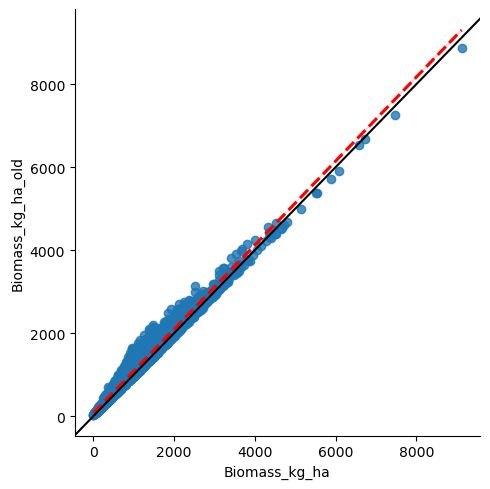

In [64]:
ax = sns.lmplot(x='Biomass_kg_ha', y='Biomass_kg_ha_old', 
                data=pd.concat([df_vor_wkly_means, df_vor_june_means, df_vor_oct_means]),
                line_kws={'linestyle': '--', 'color': 'red'})
ax.axes.flatten()[0].axline(xy1=(0, 0), slope=1, linestyle='-', color='k')

In [65]:
# label each dataset by season
df_vor_wkly_means['Season'] = 'Weekly'
df_vor_june_means['Season'] = 'June'
df_vor_oct_means['Season'] = 'October'

In [66]:
# merge datasets
df_vor_fnl_transect = pd.concat([df_vor_june_means, df_vor_oct_means])
# add coordinates
df_vor_fnl_transect = pd.merge(df_vor_fnl_transect, 
                      pd.DataFrame(gdf_transects.geometry, columns=['geometry']), 
                      how='left',
                      on='Id_transect') 

keep_cols_plot = ['Low', 'High', 'Biomass_kg_ha']
group_cols_plot = ['Year', 'Season', 'Pasture', 'Id_plot', 'Date', 'Date_mean']
df_vor_fnl_plot = pd.concat([df_vor_wkly_means[group_cols_plot + keep_cols_plot],
                             df_vor_june_means.groupby(group_cols_plot)[keep_cols_plot].mean().round(2).reset_index(), 
                             df_vor_oct_means.groupby(group_cols_plot)[keep_cols_plot].mean().round(2).reset_index()])
# add coordinates
df_vor_fnl_plot = pd.merge(df_vor_fnl_plot, 
                      pd.DataFrame(gdf_plots.geometry, columns=['geometry']), 
                      how='left',
                      on='Id_plot') 

#### Plot data for quality control

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
df_vor_fnl_plot.head(5)

,Year,Season,Pasture,Id_plot,Date,Date_mean,Low,High,Biomass_kg_ha,geometry
0,2014,Weekly,17S,17S_P1,2014-07-23,2014-07-23,6.57,22.64,1433.279284,"POLYGON ((525754.313 4519884.632, 525752.843 4..."
1,2014,Weekly,17S,17S_P1,2014-07-29,2014-07-29,5.58,31.62,1409.414842,"POLYGON ((525754.313 4519884.632, 525752.843 4..."
2,2014,Weekly,17S,17S_P1,2014-08-05,2014-08-05,5.21,29.68,1320.337580,"POLYGON ((525754.313 4519884.632, 525752.843 4..."
3,2014,Weekly,17S,17S_P1,2014-08-13,2014-08-13,8.50,26.78,1801.483162,"POLYGON ((525754.313 4519884.632, 525752.843 4..."
4,2014,Weekly,17S,17S_P2,2014-07-23,2014-07-23,4.30,14.91,950.139659,"POLYGON ((525761.121 4520134.549, 525759.651 4..."


In [69]:
df_vor_fnl_transect.head(5)

,Year,Pasture,Id_plot,Id_transect,West_High2,Transect,East_Low1,East_High1,Low,Distance,West_Low2,High,Date,Date_mean,Biomass_kg_ha_old,Biomass_kg_ha,Season,geometry
0,2014,10S,10S_P1,10S_P1_1,17.25,1.0,6.75,20.38,6.00,13.5,5.25,18.81,2014-06-12,2014-06-12,1280.30,1280.282775,June,"POLYGON ((519570.037 4521246.115, 519569.964 4..."
1,2014,10S,10S_P1,10S_P1_2,18.50,2.0,9.12,21.00,9.12,13.5,9.12,19.75,2014-06-12,2014-06-12,1719.41,1765.829861,June,"POLYGON ((519676.087 4521246.115, 519676.015 4..."
2,2014,10S,10S_P1,10S_P1_3,19.00,3.0,10.38,21.12,9.75,13.5,9.12,20.06,2014-06-12,2014-06-12,1810.92,1864.181468,June,"POLYGON ((519570.037 4521350.115, 519569.964 4..."
3,2014,10S,10S_P1,10S_P1_4,37.50,4.0,9.86,37.00,8.19,13.5,6.88,35.69,2014-06-12,2014-06-12,1972.94,1896.110089,June,"POLYGON ((519676.087 4521350.115, 519676.015 4..."
4,2014,10S,10S_P2,10S_P2_1,12.57,1.0,4.50,13.38,4.88,13.5,6.00,12.75,2014-06-12,2014-06-12,987.04,1001.525767,June,"POLYGON ((519559.297 4520994.580, 519559.224 4..."


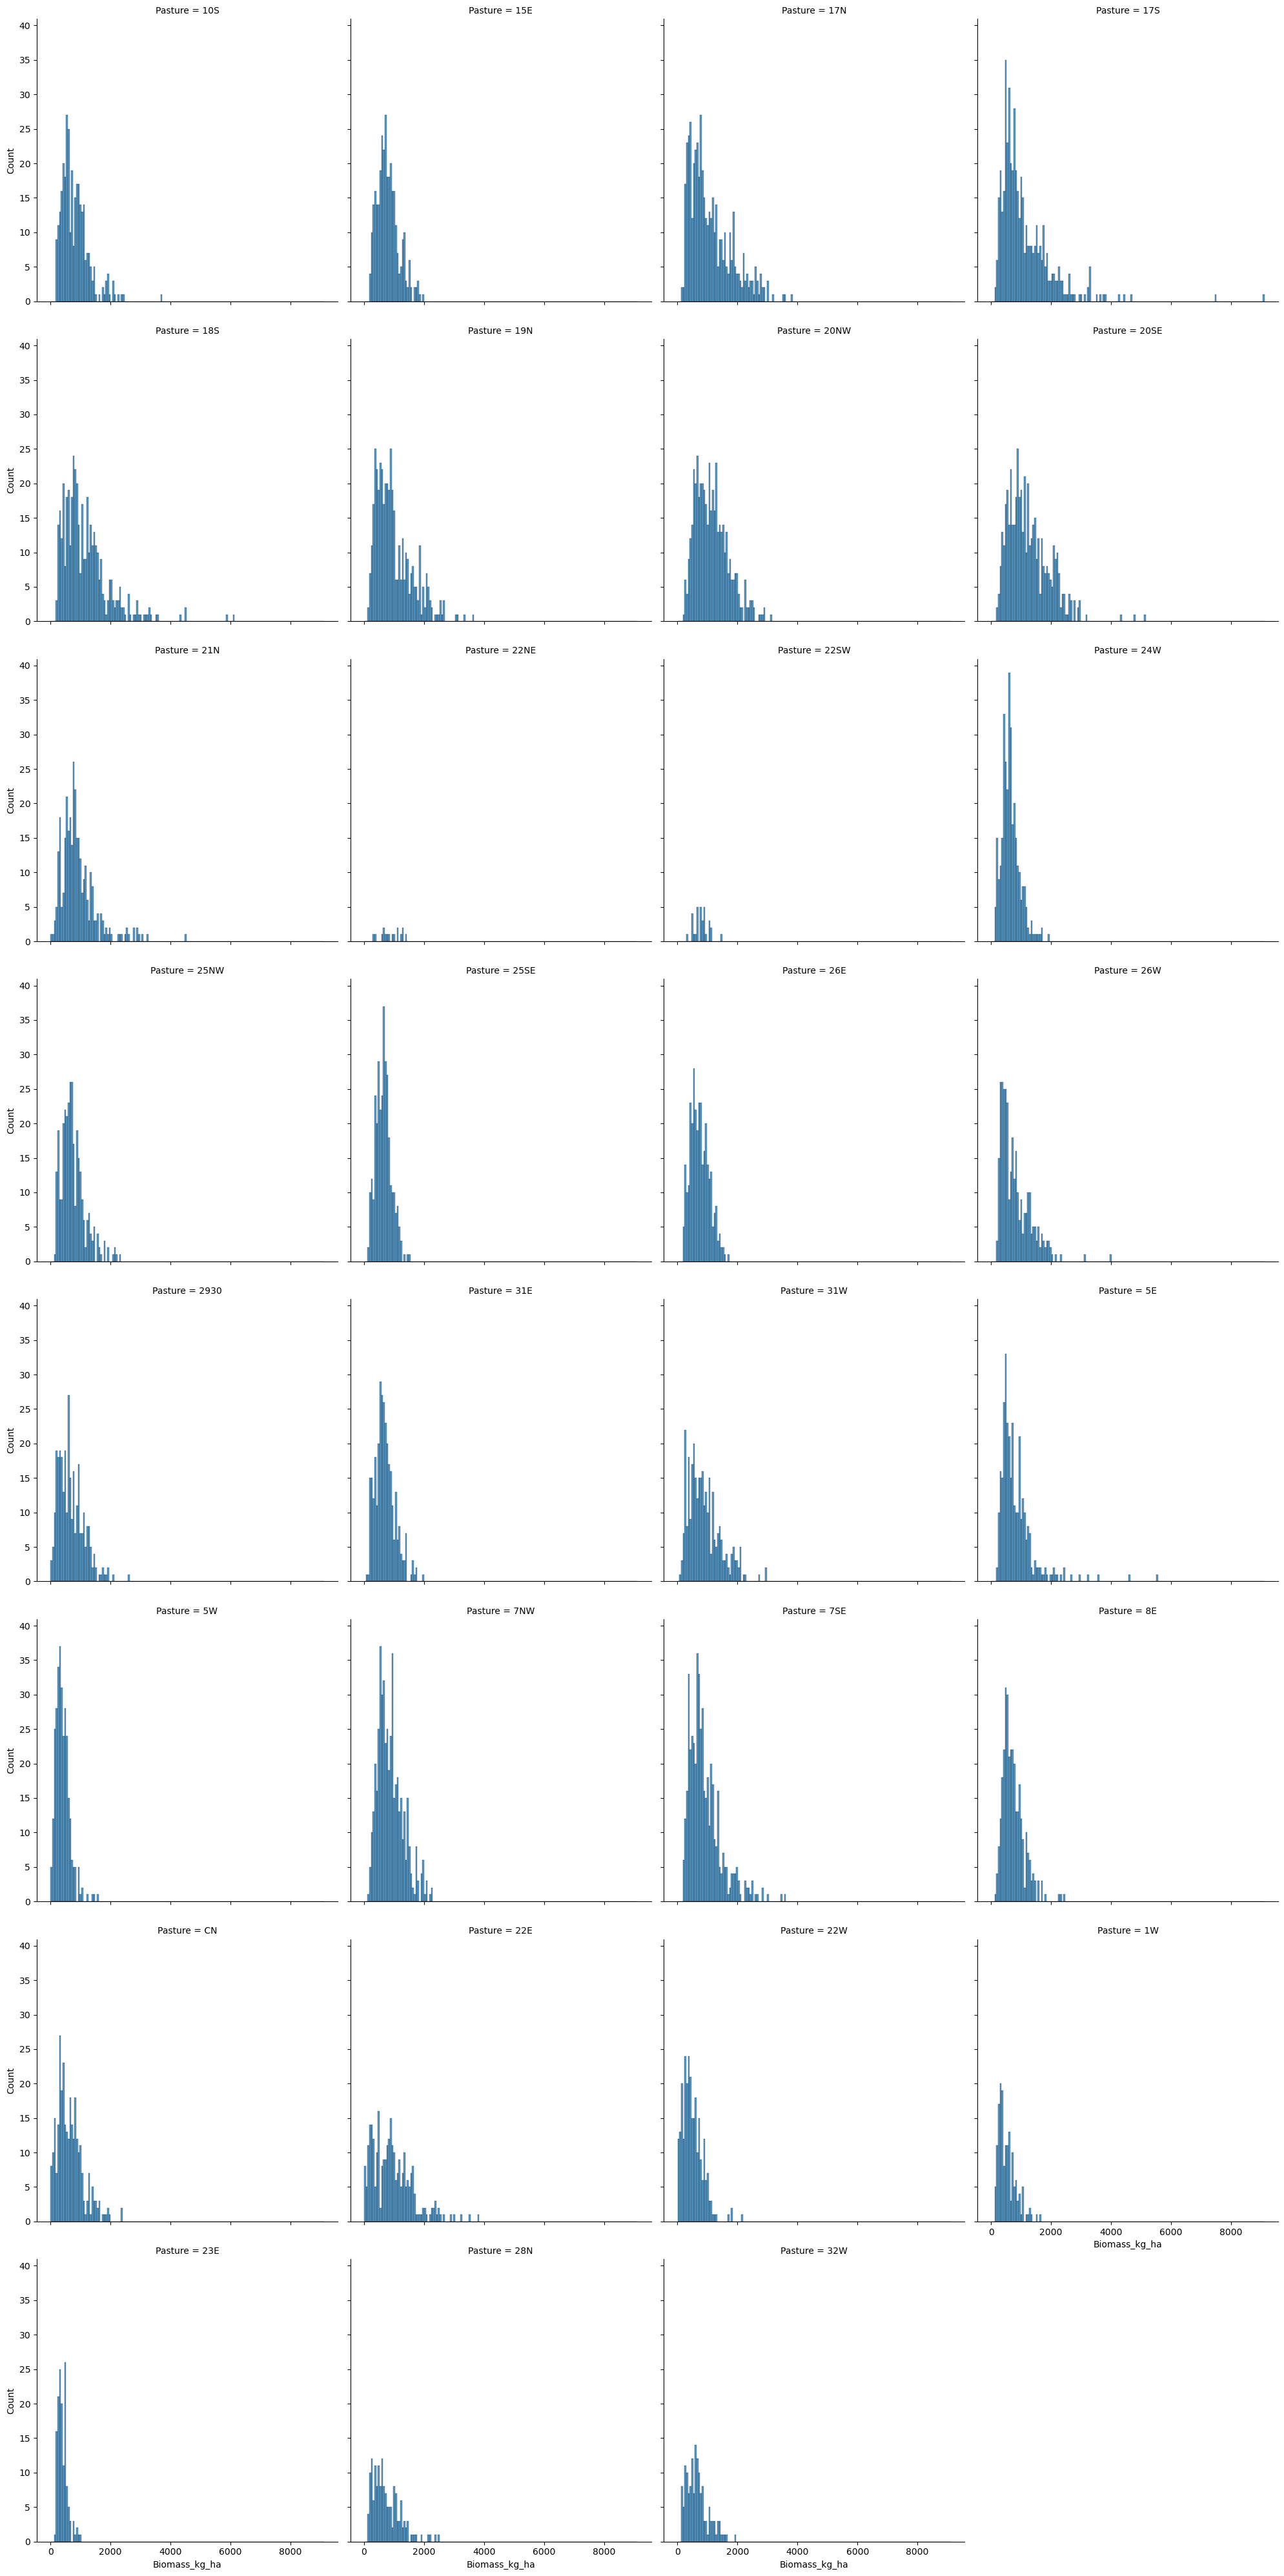

In [70]:
sns.displot(x='Biomass_kg_ha', col='Pasture', col_wrap=4, data=df_vor_fnl_transect)

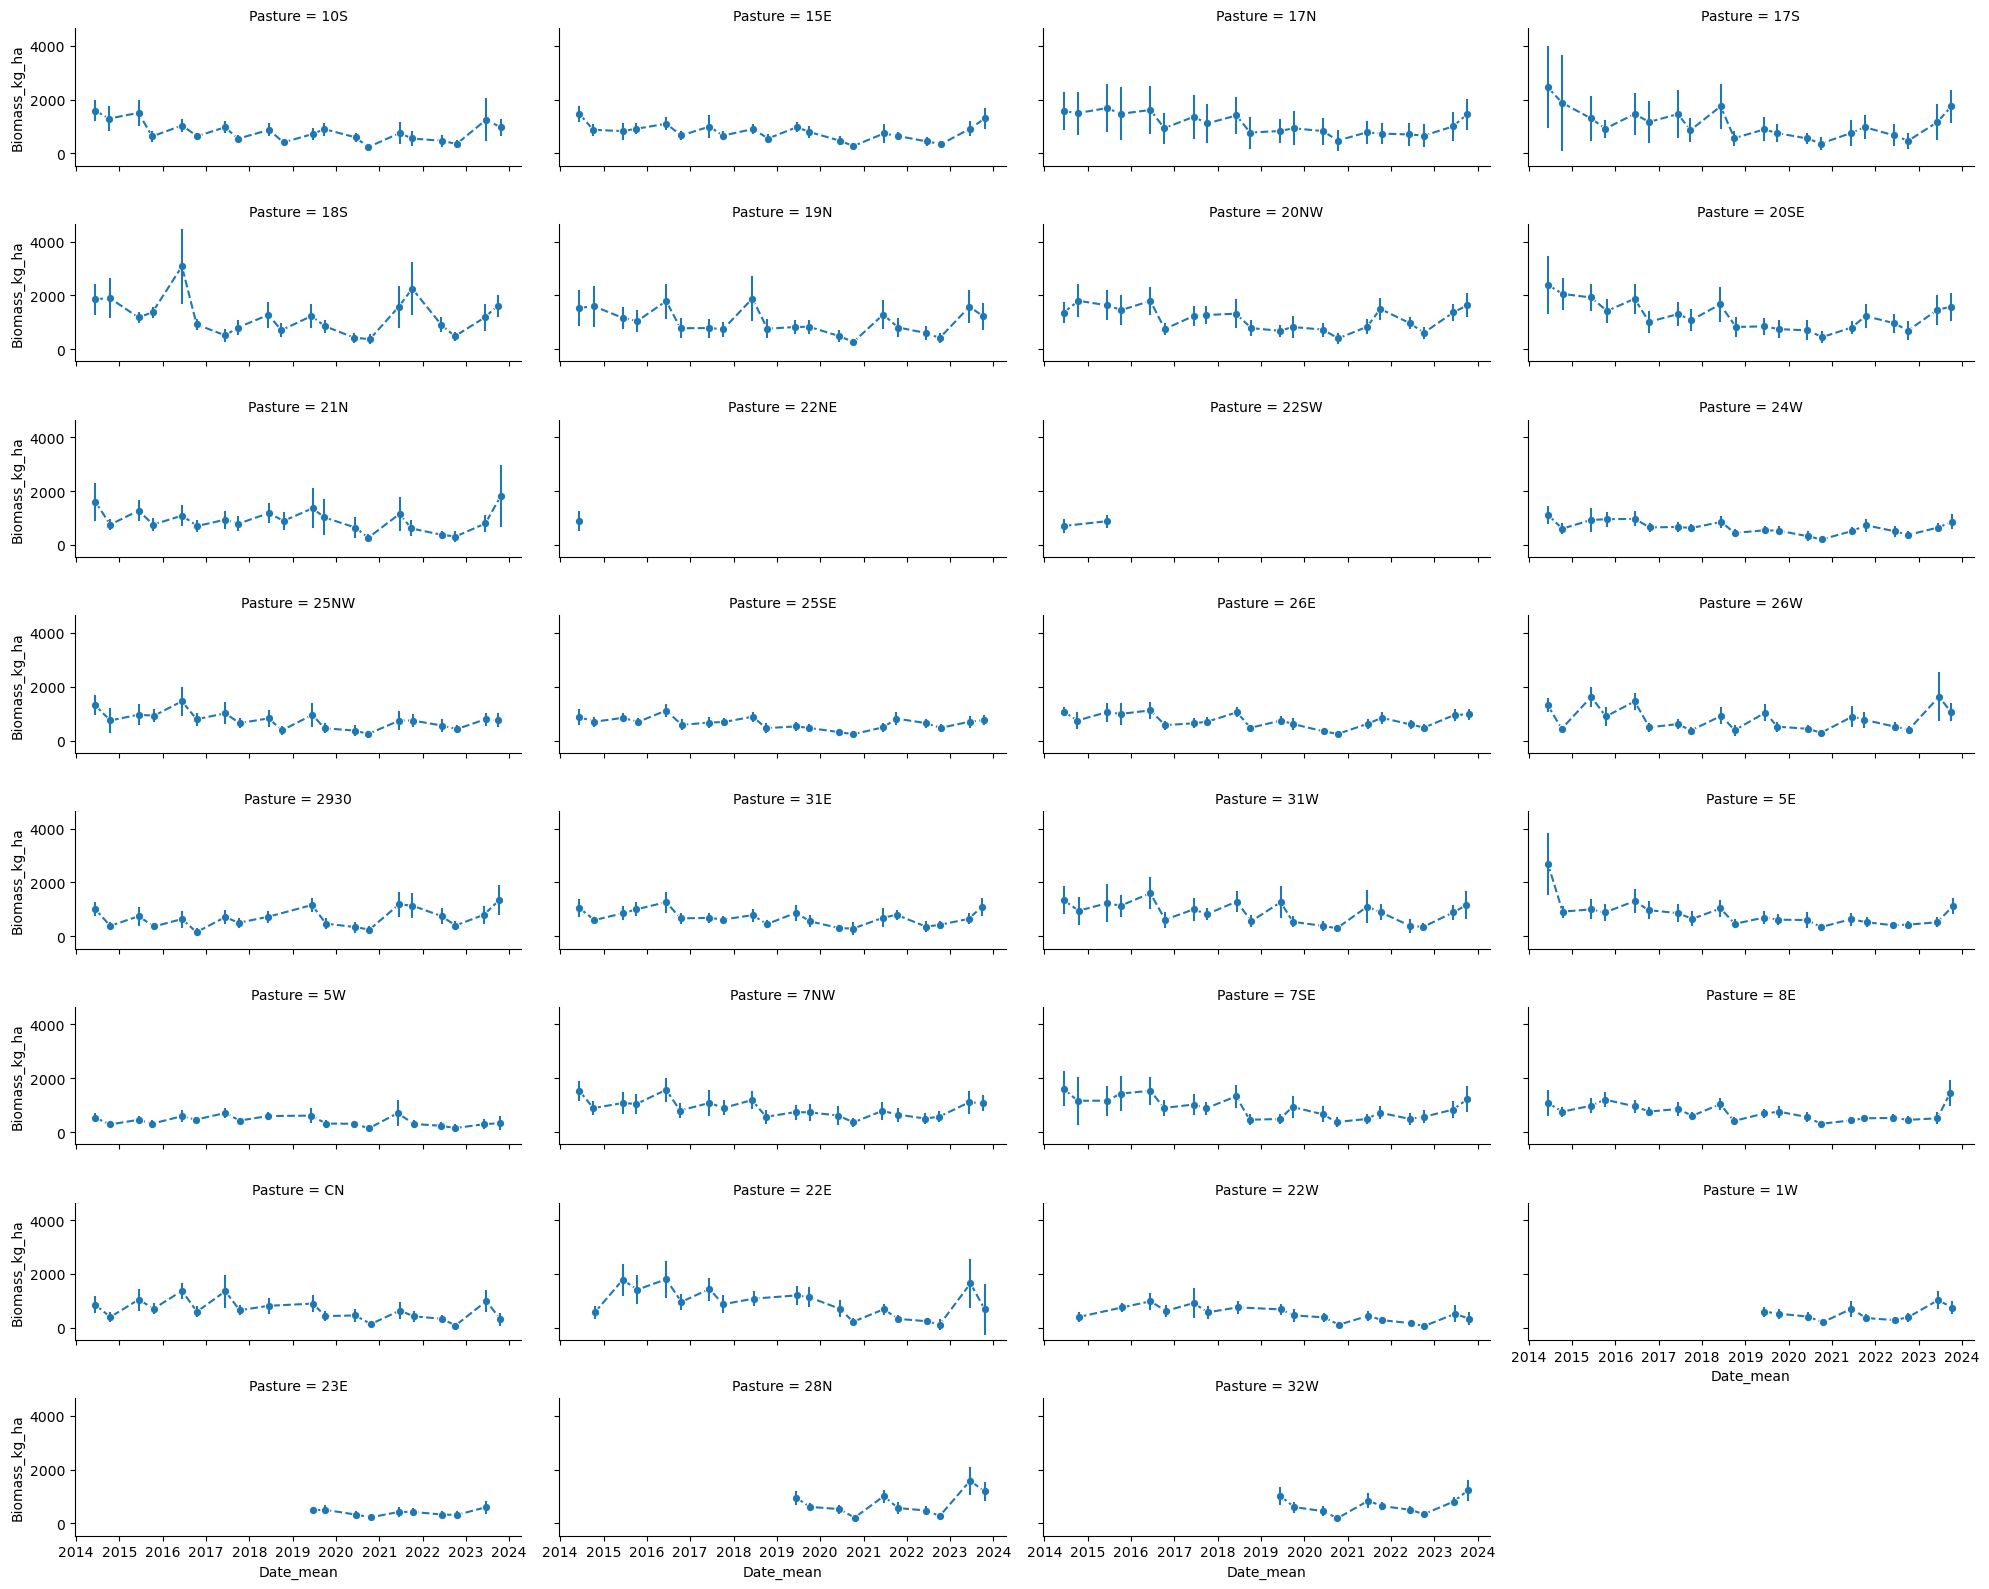

In [71]:
sns.relplot(x='Date_mean', y='Biomass_kg_ha', col='Pasture', col_wrap=4, kind='line', 
            errorbar='sd', err_style='bars', marker='o', linestyle='dashed', data=df_vor_fnl_transect, 
                height=2, aspect=2.5)

/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


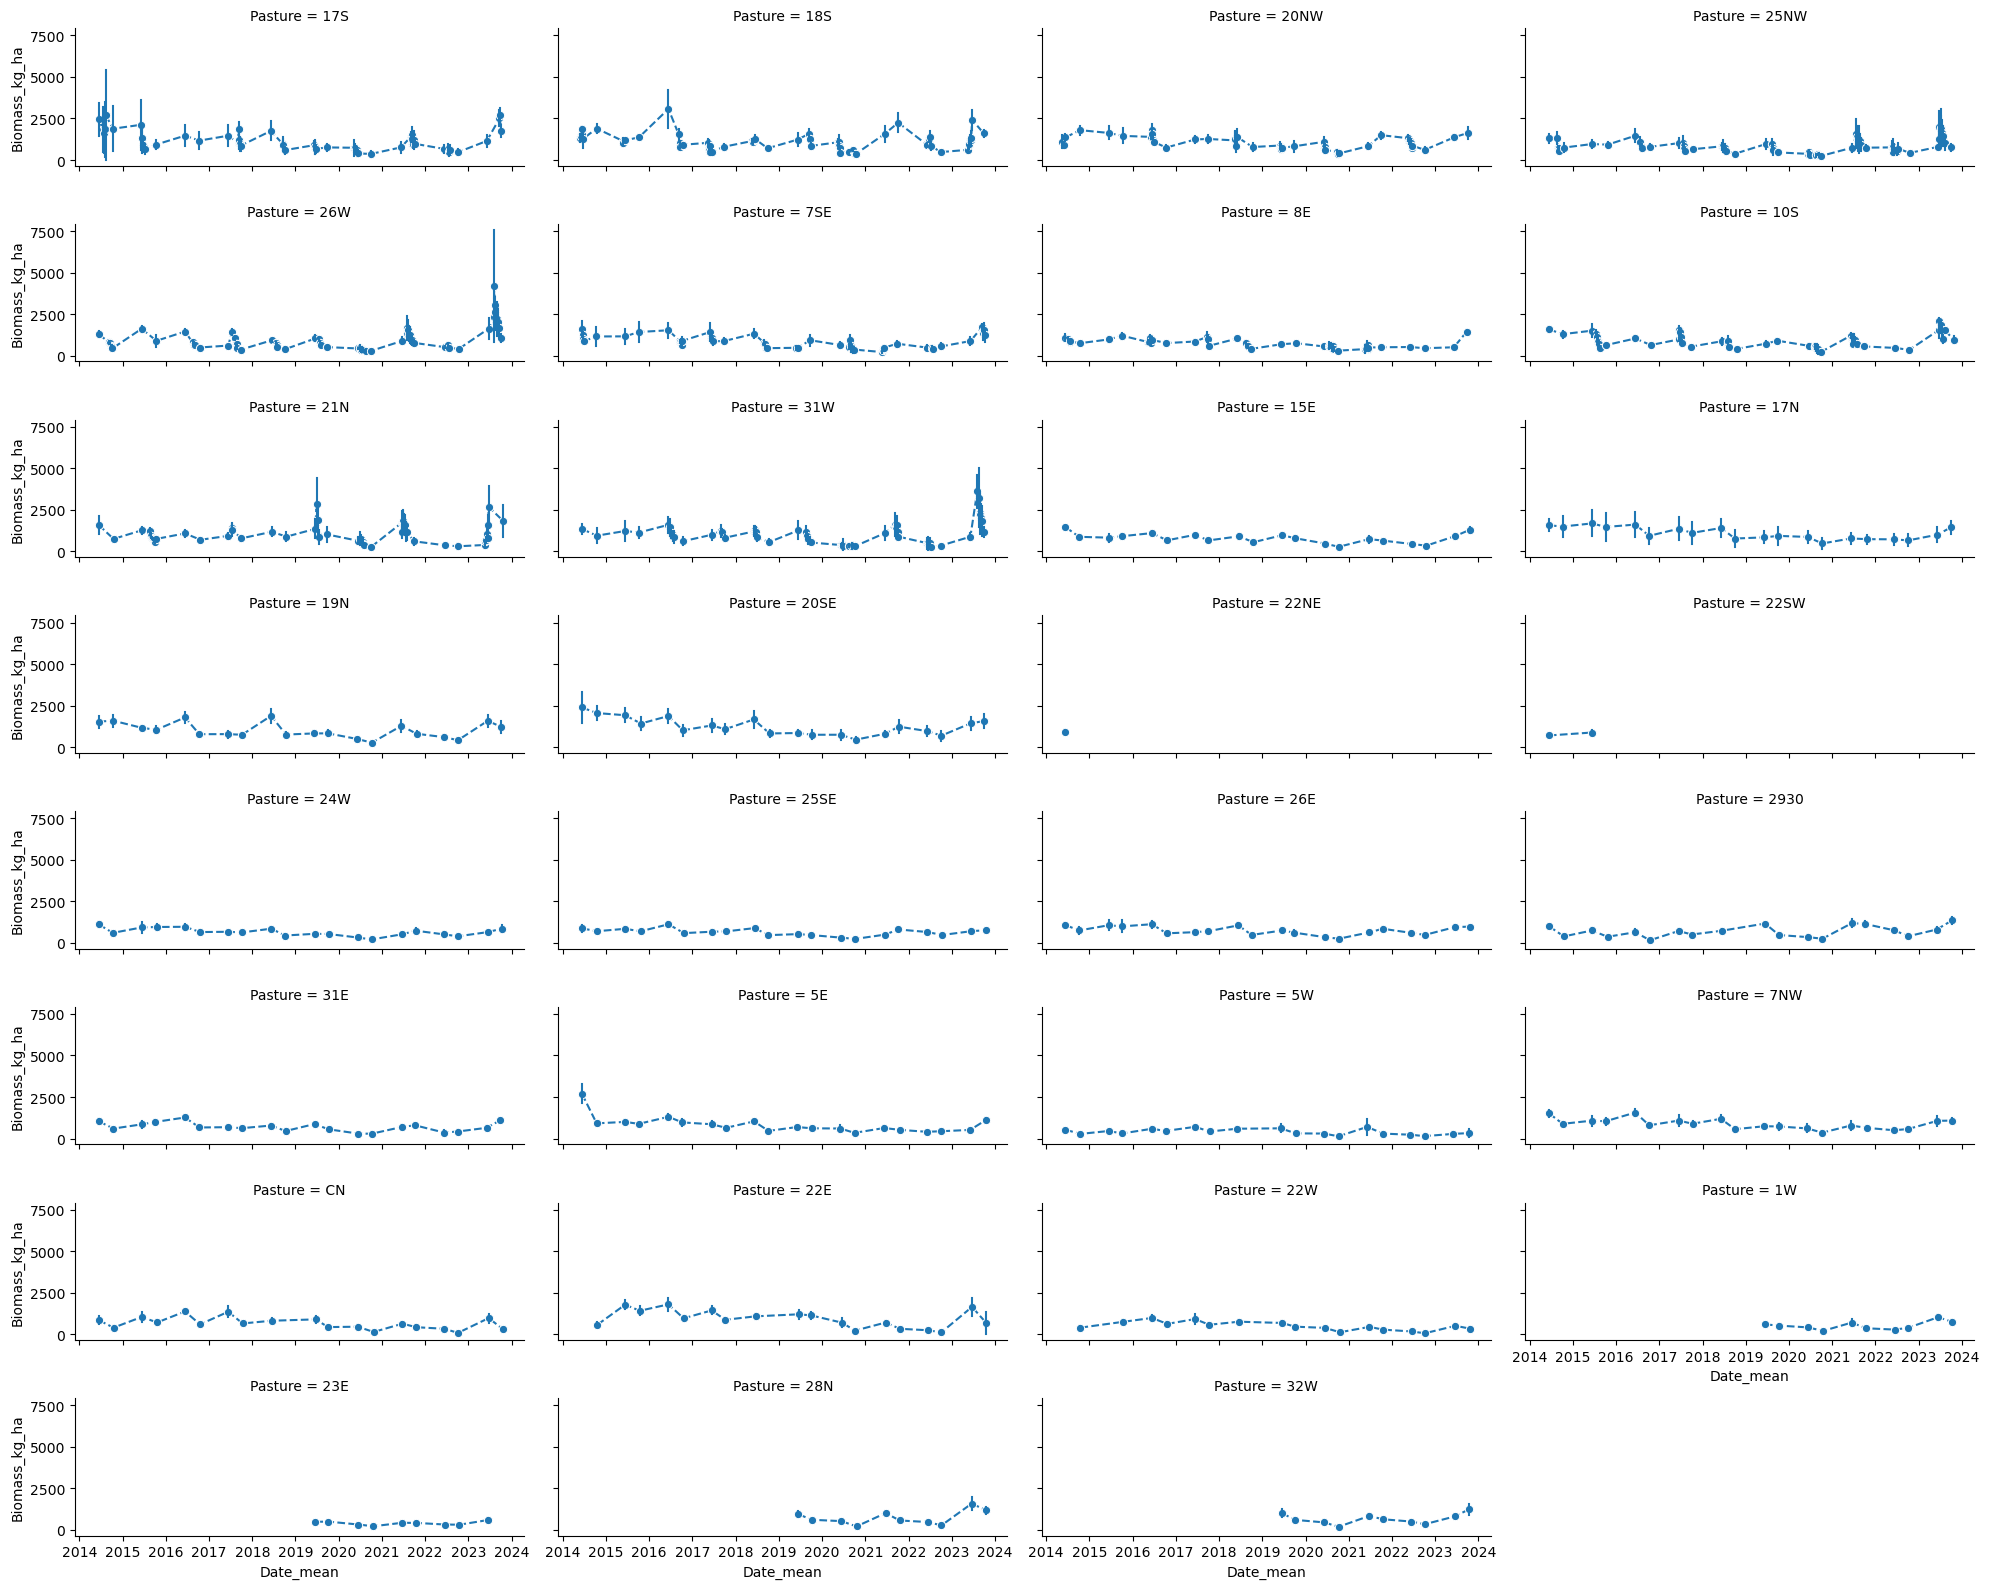

In [72]:
sns.relplot(x='Date_mean', y='Biomass_kg_ha', col='Pasture', col_wrap=4, kind='line', 
            errorbar='sd', err_style='bars', marker='o', linestyle='dashed', data=df_vor_fnl_plot, 
                height=2, aspect=2.5)

#### Save to disk

In [74]:
# define columns to be saved along with Id_*
save_cols = ['Pasture', 'Date', 'Date_mean', 'Year', 'Season', 'Low', 'High', 'Biomass_kg_ha', 'geometry']
# define pastures to be dropped based on too little data
drop_pasts = ['22NE', '22SW']
# creat final output datasets
df_vor_fnl_transect_out = df_vor_fnl_transect[~df_vor_fnl_transect['Pasture'].isin(drop_pasts)][['Id_transect'] + save_cols]
df_vor_fnl_plot_out = df_vor_fnl_plot[~df_vor_fnl_plot['Pasture'].isin(drop_pasts)][['Id_plot'] + save_cols]

In [75]:
# get year range from transect data
yrs_dat_transect = '_'.join(df_vor_fnl_transect_out['Year'].agg(['min', 'max']).astype('str'))
# save transect data to disk with custom filepath
df_vor_fnl_transect_out.to_csv('data/ground_cln/vor_' + yrs_dat_transect + '_cln_' + datetime.now().strftime('%Y_%m_%d') + '_transect.csv',
                  index=False)

# get year range from plot data
yrs_dat_plot = '_'.join(df_vor_fnl_plot_out['Year'].agg(['min', 'max']).astype('str'))
# save plot data to disk with custom filepath
df_vor_fnl_plot_out.to_csv('data/ground_cln/vor_' + yrs_dat_plot + '_cln_' + datetime.now().strftime('%Y_%m_%d') + '_plot.csv',
                  index=False)